In [ ]:
# Mathematical Modeling in SymPy

Presented by Jacob Maples (GS Comm)

<br>

_Navigate the reveal.js slideshow with the arrow keys._

_Go right to advance the slide, go down for details_

<br>

**WARNING:** This presentation contains Python!

**Contents:**

* [SymPy Introduction](#SymPy-Introduction)
  * [Example Use Case](#Example-Use-Case)
  * [Expression Trees](#Expression-Trees)
* [Adding Functionality](#Adding-Functionality)
  * [Converting Equations to Text](#Convert-SymPy-equations-to-text)
  * [Converting Equations to LaTeX](#Convert-SymPy-equations-to-LaTeX)
  * [Rearranging Equations](#Rearranging-Equations)
  * [Evaluating Expressions](#Evaluating-Expressions)
  * [Compiling Expressions](#Compiling-Expressions)
* [All together now](#All-together-now)


* [Putting It All Together](#Putting-Things-Together)
* [More Information](#More-Information)
  * [Sympy Help](#SymPy-Help)
  * [Upgrading Code to Python 3](#Upgrading-Code-to-Python-3)
  * [Interesting Links / References](#Interesting-Links-/-References) 

**To Do:**

* wrap sympy.subsm sympy.solve
* look at Kaggle notebook for creating a cell, use to generate a %%latex cell
* create interface table
* create entity figure (use script at work)
* figure out multiline Latex print with sympy printer (no %%latex cell)
* ipython nbconvert myslides.ipynb --to slides --post serve


## SymPy Introduction

Links: [Top](#Mathematical-Modeling-in-SymPy)
[Intro](#SymPy-Introduction) 
[Text](#Convert-SymPy-equations-to-text)
[LaTeX](#Convert-SymPy-equations-to-Latex)
[Solver](#Rearranging-Equations)
[Evaluating](#Evaluating-Expressions)
[Designs](#Putting-Things-Together)
[Help][]
[Help]: #Help-(Doctrings)

In [1]:
import sympy

In [2]:
print(sympy.__doc__)


SymPy is a Python library for symbolic mathematics. It aims to become a
full-featured computer algebra system (CAS) while keeping the code as simple
as possible in order to be comprehensible and easily extensible.  SymPy is
written entirely in Python. It depends on mpmath, and other external libraries
may be optionally for things like plotting support.

See the webpage for more information and documentation:

    http://sympy.org




In [3]:
help(sympy)

Help on package sympy:

NAME
    sympy

DESCRIPTION
    SymPy is a Python library for symbolic mathematics. It aims to become a
    full-featured computer algebra system (CAS) while keeping the code as simple
    as possible in order to be comprehensible and easily extensible.  SymPy is
    written entirely in Python. It depends on mpmath, and other external libraries
    may be optionally for things like plotting support.
    
    See the webpage for more information and documentation:
    
        http://sympy.org

PACKAGE CONTENTS
    abc
    assumptions (package)
    benchmarks (package)
    calculus (package)
    categories (package)
    combinatorics (package)
    concrete (package)
    conftest
    core (package)
    crypto (package)
    deprecated (package)
    diffgeom (package)
    external (package)
    functions (package)
    galgebra
    geometry (package)
    integrals (package)
    interactive (package)
    liealgebras (package)
    logic (package)
    matrices (package)

Here are some examples of basic symbol operations:

In [4]:
x = sympy.Symbol('x')
y = x
x, x*2+1, y, type(y), x == y

(x, 2*x + 1, x, sympy.core.symbol.Symbol, True)

In [5]:
try:
    x*y+z
except NameError as e:
    print(e)

name 'z' is not defined


In [6]:
sympy.symbols('x5:10'), sympy.symbols('x:z')

((x5, x6, x7, x8, x9), (x, y, z))

In [7]:
X = sympy.numbered_symbols('variable')
[ next(X) for i in range(5) ]

[variable0, variable1, variable2, variable3, variable4]

SymPy also handles expressions:

In [8]:
e = sympy.sympify('x*(x-1)+(x-1)')
e, sympy.factor(e), sympy.expand(e)

(x*(x - 1) + x - 1, (x - 1)*(x + 1), x**2 - 1)

But most work of interest is more than single expressions, so here is a helper function to handle systems of equations.

In [9]:
from process import parseExpr
help(parseExpr)

Help on function parseExpr in module process:

parseExpr(expr='')
    Helper function to iterate through a list of equations



In [10]:
import inspect
print(inspect.getsource(parseExpr))

def parseExpr(expr=''):
    '''Helper function to iterate through a list of equations'''
    err = 'Malformed expression! Does not match "y = f(x)"\n  {0:s}'
    for s in expr.strip().split('\n'):
        # Parse anything that looks like an equation and isn't commented out
        if ('=' in s) and (s[0] != '#'):
            # convert expression to sympy
            y, f = list(map(str.strip, s.split('=',1)))
            y = sympy.Symbol(y)
            f = sympy.sympify(f)
            assert type(y) == sympy.symbol.Symbol, err.format(s)
            yield (y, f)



### Example Use Case

Let's use a simple example to explore the additional functionality.  Performing a 2-D rotation involves multiple dependant variables, independant variables, and functions.

$x' = x \cos \theta - y \sin \theta$

$y' = x \sin \theta + y \cos \theta$

In [11]:
inputs='x y theta'
outputs="x' y'"
expr='''
x' = x*cos(theta) - y*sin(theta)
y' = x*sin(theta) + y*cos(theta)
'''

ins = sympy.symbols(inputs)
outs = sympy.symbols(outputs)
eqn = dict(parseExpr(expr))

# No quote marks, the dictionary keys are SymPy symbols
ins, outs, eqn

((x, y, theta),
 (x', y'),
 {x': x*cos(theta) - y*sin(theta), y': x*sin(theta) + y*cos(theta)})

### Expression Trees ###

SymPy maintains a tree for all expressions. Everything in SymPy has .args and .func arguments that allow the expression (at that point in the tree) to be reconstructed. The .func argument is essentially the same as calling type and specifies whether the node is a add, multiply, cosine, some other function or a symbol. As you might expect, the .args attribute for leaves is empty.

In [12]:
expr_inputs = set()
expr_functs = set()
for arg in sympy.preorder_traversal(eqn[outs[0]]):
    print(arg.func, '\t', arg, '\t', arg.args)
    if arg.is_Symbol:
        expr_inputs.add(arg)
    elif arg.is_Function:
        expr_functs.add(arg.func)    
expr_inputs, expr_functs

<class 'sympy.core.add.Add'> 	 x*cos(theta) - y*sin(theta) 	 (x*cos(theta), -y*sin(theta))
<class 'sympy.core.mul.Mul'> 	 x*cos(theta) 	 (x, cos(theta))
<class 'sympy.core.symbol.Symbol'> 	 x 	 ()
cos 	 cos(theta) 	 (theta,)
<class 'sympy.core.symbol.Symbol'> 	 theta 	 ()
<class 'sympy.core.mul.Mul'> 	 -y*sin(theta) 	 (-1, y, sin(theta))
<class 'sympy.core.numbers.NegativeOne'> 	 -1 	 ()
<class 'sympy.core.symbol.Symbol'> 	 y 	 ()
sin 	 sin(theta) 	 (theta,)
<class 'sympy.core.symbol.Symbol'> 	 theta 	 ()


({y, x, theta}, {cos, sin})

## Adding Functionality
Before we go on, let's create a class around parseExpr so we can add object-oriented functionality.

In [13]:
from process import Block
print(inspect.getdoc(Block))
b = Block(expr, '2-D Rotate', inputs, outputs)

Block(expr, inputs='', outputs='', functions={})
Generic processing block that performs specified calculations on given inputs
in such a way to ease documentation
    
Creating Block(expr="\nx' = x*cos(theta) - y*sin(theta)\ny' = x*sin(theta) + y*cos(theta)\n", name='2-D Rotate', inputs='x y theta', outputs="x' y'", functions={})
outs=(x', y')


In [14]:
# spoiler alert!
print(inspect.getsource(Block.__init__))

    def __init__(self, expr, name='', inputs='', outputs='', functions={}):
        '''Create a Block instance'''
        
        if Block.verbose:
            s = 'Creating Block(expr={:s}, name={:s}, inputs={:s}, outputs={:s}, functions='
            s = s.format(*list(map(repr,[expr, name, inputs, outputs])))+'{'
            if functions:
                s_functions = []
                for k, v in functions.items():
                    s2 = k+':'+v.__name__
                    args, varargs, keywords, defaults = getargspec(v)
                    if varargs != None:
                        args += ['*args']
                    if keywords != None:
                        args += ['*kwargs']
                    s2 += '('+','.join(args)+')'
                    s_functions.append(s2)
                s += ','.join(s_functions)
            print(s+'})')
        
        self.name = name
        self.user = functions
        
        # save in list form for ordered outputs
        eqn = 

### Convert SymPy equations to text

Links: [Top](#Mathematical-Modeling-in-SymPy)
[Intro](#SymPy-Introduction) 
[Text](#Convert-SymPy-equations-to-text)
[LaTeX](#Convert-SymPy-equations-to-Latex)
[Solver](#Rearranging-Equations)
[Evaluating](#Evaluating-Expressions)
[Designs](#Putting-Things-Together)
[Help][]
[Help]: #Help-(Doctrings)

In [15]:
print('\n'.join( str(k)+' = '+sympy.pretty(v) for k,v in eqn.items() ))
print()
print('\n'.join( str(k)+' = '+str(v) for k,v in eqn.items() ))

x' = x⋅cos(θ) - y⋅sin(θ)
y' = x⋅sin(θ) + y⋅cos(θ)

x' = x*cos(theta) - y*sin(theta)
y' = x*sin(theta) + y*cos(theta)


So our Block instance can do the same thing, it needs to have pretty and \_\_str\_\_ functions defined.  A \_\_repr\_\_ function could also be used to return a separate representation of the object.

In [16]:
b.pretty()
print(b)


Block: 2-D Rotate
x' = x⋅cos(θ) - y⋅sin(θ)
y' = x⋅sin(θ) + y⋅cos(θ)
Block: 2-D Rotate
Eq(x', x*cos(theta) - y*sin(theta))
Eq(y', x*sin(theta) + y*cos(theta))


In [17]:
print(inspect.getsource(b.pretty))
print(inspect.getsource(b.__str__))

    def pretty(self):
        '''Show a SymPy pretty print version of Block equations'''
        print('\nBlock:', self.name)
        print('\n'.join( sympy.pretty(e) for e in self.eqn ))

    def __str__(self):
        '''Support str calls on Block instances'''
        s  = 'Block: '+str(self.name)+'\n'
        s += '\n'.join( str(e).replace('==','=') for e in self.eqn )
        return s



### Convert SymPy equations to LaTeX

Strings are well and good, but don't quite cut it for publications and presentations

Links: [Top](#Mathematical-Modeling-in-SymPy)
[Intro](#SymPy-Introduction) 
[Text](#Convert-SymPy-equations-to-text)
[LaTeX](#Convert-SymPy-equations-to-Latex)
[Solver](#Rearranging-Equations)
[Evaluating](#Evaluating-Expressions)
[Designs](#Putting-Things-Together)
[Help][]
[Help]: #Help-(Doctrings)

In [18]:
# Generate a LaTeX string for the Jupyter notebook to render
print(' \\\\\n'.join([ str(k)+' = '+sympy.latex(v) for k, v in eqn.items() ]))

x' = x \cos{\left (\theta \right )} - y \sin{\left (\theta \right )} \\
y' = x \sin{\left (\theta \right )} + y \cos{\left (\theta \right )}


In [19]:
%%latex
$
x' = x \cos{\left (\theta \right )} - y \sin{\left (\theta \right )} \\
y' = x \sin{\left (\theta \right )} + y \cos{\left (\theta \right )}
$

<IPython.core.display.Latex object>

For our Block instance, the latex function doesn't need any arguments, so it can be handled as an attribute

In [20]:
print(b.latex)

\underline{\verb;Block: 2-D Rotate;} \\ 
x' = x \cos{\left (\theta \right )} - y \sin{\left (\theta \right )} \\ 
y' = x \sin{\left (\theta \right )} + y \cos{\left (\theta \right )}


In [21]:
%%latex
$
\underline{\verb;Block: 2-D Rotate;} \\ 
x' = x \cos{\left (\theta \right )} - y \sin{\left (\theta \right )} \\ 
y' = x \sin{\left (\theta \right )} + y \cos{\left (\theta \right )}
$

<IPython.core.display.Latex object>

In [22]:
f = inspect.getsource(Block).split('def ')
for i,s in enumerate(f):
    if s.startswith('latex'):
        # grab the last 2 lines from the previous code block, suppress the final newline
        print('\n'.join(f[i-1].rsplit('\n',2)[-2:]), end="")
        print('def '+s.strip())

    @property
    def latex(self):
        '''generate a latex version of Block equations'''
        # \verb;*; leaves contents unformatted
        s  = r'\underline{\verb;Block: '+str(self.name)+';} \\\\ \n'
        s += ' \\\\ \n'.join( sympy.latex(e) for e in self.eqn )
        return s


As a property, the latex function above is implicitly called instead of returning the function itself.  Attempting to use `inspect.getsource` results in a `TypeError` since the LaTeX output isn't source code.

In [23]:
try:
    inspect.getsource(getattr(Block,'latex'))
except TypeError as e:
    print(type(e),' : ', e)

<class 'TypeError'>  :  <property object at 0x000002861B91AC28> is not a module, class, method, function, traceback, frame, or code object


We've seen a couple SymPy output formats. The `init_printing` function provides a lot of additional control over how symbols and expressions are shown, including LaTeX.

In [24]:
b.eqn

(Eq(x', x*cos(theta) - y*sin(theta)), Eq(y', x*sin(theta) + y*cos(theta)))

In [25]:
sympy.init_printing(use_latex=True)
#sympy.init_printing(use_latex=False)

In [26]:
b.eqn

In [27]:
sympy.Matrix(b.eqn)

⎡x' = x⋅cos(θ) - y⋅sin(θ)⎤
⎢                        ⎥
⎣y' = x⋅sin(θ) + y⋅cos(θ)⎦

In [28]:
help(sympy.init_printing)

Help on function init_printing in module sympy.interactive.printing:

init_printing(pretty_print=True, order=None, use_unicode=None, use_latex=None, wrap_line=None, num_columns=None, no_global=False, ip=None, euler=False, forecolor='Black', backcolor='Transparent', fontsize='10pt', latex_mode='equation*', print_builtin=True, str_printer=None, pretty_printer=None, latex_printer=None)
    Initializes pretty-printer depending on the environment.
    
    Parameters
    
    pretty_print: boolean
        If True, use pretty_print to stringify or the provided pretty
        printer; if False, use sstrrepr to stringify or the provided string
        printer.
    order: string or None
        There are a few different settings for this parameter:
        lex (default), which is lexographic order;
        grlex, which is graded lexographic order;
        grevlex, which is reversed graded lexographic order;
        old, which is used for compatibility reasons and for long expressions;
        N

## Rearranging Equations

SymPy can also handle sets of equations (`sympy.Eq` instances) to handle intermediate values or solve equations in terms of desired variables.  `Block` can catch up later.

Links: [Top](#Mathematical-Modeling-in-SymPy)
[Intro](#SymPy-Introduction) 
[Text](#Convert-SymPy-equations-to-text)
[LaTeX](#Convert-SymPy-equations-to-Latex)
[Solver](#Rearranging-Equations)
[Evaluating](#Evaluating-Expressions)
[Designs](#Putting-Things-Together)
[Help][]
[Help]: #Help-(Doctrings)

In [29]:
inputs='x y theta'
outputs="x' y'"
expr='''
x' = x*c - y*s
y' = x*s + y*c
c = cos(theta)
s = sin(theta)
'''

ins2 = sympy.symbols(inputs)
outs2 = sympy.symbols(outputs)
hidden2 = sympy.symbols('c s')
eqn2 = tuple(sympy.Eq(k,v) for k, v in parseExpr(expr))
ins2, outs2, eqn2

In [30]:
sympy.solve(eqn2, outs2+hidden2)

In [31]:
help(sympy.solve)

Help on function solve in module sympy.solvers.solvers:

solve(f, *symbols, **flags)
    Algebraically solves equations and systems of equations.
    
    Currently supported are:
        - polynomial,
        - transcendental
        - piecewise combinations of the above
        - systems of linear and polynomial equations
        - sytems containing relational expressions.
    
    Input is formed as:
    
    * f
        - a single Expr or Poly that must be zero,
        - an Equality
        - a Relational expression or boolean
        - iterable of one or more of the above
    
    * symbols (object(s) to solve for) specified as
        - none given (other non-numeric objects will be used)
        - single symbol
        - denested list of symbols
          e.g. solve(f, x, y)
        - ordered iterable of symbols
          e.g. solve(f, [x, y])
    
    * flags
        'dict'=True (default is False)
            return list (perhaps empty) of solution mappings
        'set'=True (

## Evaluating Expressions

SymPy can evaluate equations symbolically (`.subs` function) or numerically (`.evalf` function), at specified level of precision.

Links: [Top](#Mathematical-Modeling-in-SymPy)
[Intro](#SymPy-Introduction) 
[Text](#Convert-SymPy-equations-to-text)
[LaTeX](#Convert-SymPy-equations-to-Latex)
[Solver](#Rearranging-Equations)
[Evaluating](#Evaluating-Expressions)
[Designs](#Putting-Things-Together)
[Help][]
[Help]: #Help-(Doctrings)

In [32]:
x = sympy.Symbol("x'")
eqn[x].subs(zip(ins, (1, 1, 45)))

In [33]:
eqn[x].evalf(4, subs=dict(zip(ins, (1, 1, 45))))

In [34]:
# sanity check with NumPy
import numpy as np
-1*np.sin(45) + np.cos(45)

In [35]:
e = sympy.sympify('sqrt(x)')
print(e.evalf(subs={'x':2}))
print(e.evalf(60, subs={'x':2}))

1.41421356237310
1.41421356237309504880168872420969807856967187537694807317668


In [36]:
print(sympy.pi.evalf())
print(sympy.pi.evalf(100))

3.14159265358979
3.141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117068


In [37]:
help(eqn[x].subs)

Help on method subs in module sympy.core.basic:

subs(*args, **kwargs) method of sympy.core.add.Add instance
    Substitutes old for new in an expression after sympifying args.
    
    `args` is either:
      - two arguments, e.g. foo.subs(old, new)
      - one iterable argument, e.g. foo.subs(iterable). The iterable may be
         o an iterable container with (old, new) pairs. In this case the
           replacements are processed in the order given with successive
           patterns possibly affecting replacements already made.
         o a dict or set whose key/value items correspond to old/new pairs.
           In this case the old/new pairs will be sorted by op count and in
           case of a tie, by number of args and the default_sort_key. The
           resulting sorted list is then processed as an iterable container
           (see previous).
    
    If the keyword ``simultaneous`` is True, the subexpressions will not be
    evaluated until all the substitutions have been

In [38]:
help(eqn[x].evalf)

Help on method evalf in module sympy.core.evalf:

evalf(n=15, subs=None, maxn=100, chop=False, strict=False, quad=None, verbose=False) method of sympy.core.add.Add instance
    Evaluate the given formula to an accuracy of n digits.
    Optional keyword arguments:
    
        subs=<dict>
            Substitute numerical values for symbols, e.g.
            subs={x:3, y:1+pi}. The substitutions must be given as a
            dictionary.
    
        maxn=<integer>
            Allow a maximum temporary working precision of maxn digits
            (default=100)
    
        chop=<bool>
            Replace tiny real or imaginary parts in subresults
            by exact zeros (default=False)
    
        strict=<bool>
            Raise PrecisionExhausted if any subresult fails to evaluate
            to full accuracy, given the available maxprec
            (default=False)
    
        quad=<str>
            Choose algorithm for numerical quadrature. By default,
            tanh-sinh quadra

### Compiling Expressions
For efficiency, `sympy.lambdify` is preferred for numerical analysis. It supports mathematical functions from [`math`](https://docs.python.org/3/library/math.html#module-math), [`sympy.Function`](http://docs.sympy.org/latest/modules/functions/index.html#contents), or [`mpmath`](http://mpmath.org/doc/current/functions/index.html).  Since these library functions are compiled Python, C, or even Fortran, they are significantly faster than `sympy.evalf`.

In [39]:
rad=np.linspace(0, np.pi, 8+1)
f = sympy.lambdify(ins, eqn[x], 'numpy')
%timeit f(1,0,rad)

The slowest run took 16.35 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 4.22 µs per loop


In [40]:
%%timeit 
for i in rad: # evalf doesn't support arrays!
    eqn[x].evalf(subs={'x':1.0,'y':0.0,'theta':i})

10 loops, best of 3: 85.5 ms per loop


SymPy also supports `uFuncify` for generating binary functions (using f2py and Cython) and `Theano` for GPU support. These options are discussed in the [SymPy documentation](http://docs.sympy.org/latest/modules/numeric-computation.html).

In [41]:
help(sympy.lambdify)

Help on function lambdify in module sympy.utilities.lambdify:

lambdify(args, expr, modules=None, printer=None, use_imps=True, dummify=True)
    Returns a lambda function for fast calculation of numerical values.
    
    If not specified differently by the user, SymPy functions are replaced as
    far as possible by either python-math, numpy (if available) or mpmath
    functions - exactly in this order. To change this behavior, the "modules"
    argument can be used. It accepts:
    
     - the strings "math", "mpmath", "numpy", "numexpr", "sympy"
     - any modules (e.g. math)
     - dictionaries that map names of sympy functions to arbitrary functions
     - lists that contain a mix of the arguments above, with higher priority
       given to entries appearing first.
    
    The default behavior is to substitute all arguments in the provided
    expression with dummy symbols. This allows for applied functions (e.g.
    f(t)) to be supplied as arguments. Call the function with dumm

Note that `sympy.lambdify` also supports custom functions (e.g. conditional operations or reshaping arrays).  These custom functions can also be optimized for computing as easily as including a `@jit` decorator from the [numba](http://numba.pydata.org/) library.

In [42]:
def my_sample(x):
    r = len(x) >> 1
    return np.reshape(x[:2*r], (r,2))

x = np.linspace(0, np.pi, 9+1)
print(x*180/np.pi) # degrees

[   0.   20.   40.   60.   80.  100.  120.  140.  160.  180.]


In [43]:
e = sympy.sympify('1+sample(x)')
print(e)

f = sympy.lambdify(sympy.Symbol('x'), e, {'sample':my_sample})
f(x)

sample(x) + 1


array([[ 1.        ,  1.34906585],
       [ 1.6981317 ,  2.04719755],
       [ 2.3962634 ,  2.74532925],
       [ 3.0943951 ,  3.44346095],
       [ 3.7925268 ,  4.14159265]])

In [44]:
f = sympy.lambdify(sympy.Symbol('x'),               # inputs
                   sympy.sympify('sample(cos(x))'), # expressions
                   ('numpy', {'sample':my_sample})) # functions
# Note: Can also use empty function dictionary for consistency
f(x)

array([[ 1.        ,  0.93969262],
       [ 0.76604444,  0.5       ],
       [ 0.17364818, -0.17364818],
       [-0.5       , -0.76604444],
       [-0.93969262, -1.        ]])

However, the documentation could be better.  (_Earlier versions didn't even include the expresion._)

In [45]:
help(f)

Help on function <lambda> in module numpy:

<lambda> lambda _Dummy_26
    Created with lambdify. Signature:
    
    func(x)
    
    Expression:
    
    sample(cos(x))



For more control over the output function, including the `__doc__`, `__name__`, and `__signature__` attributes used by the `help` function, let's revisit the Block class to wrap the functionality seen so far.

## All together now

As we've seen, all the information is available for a more informative way to manipulate and evaluate systems of equations.

In [47]:
b2 = Block('''c = cos(theta)
s = sin(theta)
x' = x*c - y*s
y' = x*s + y*c
''', '2-D Rotate', 'x y theta', "x' y'")
print('\n',vars(b2))

Creating Block(expr="c = cos(theta)\ns = sin(theta)\nx' = x*c - y*s\ny' = x*s + y*c\n", name='2-D Rotate', inputs='x y theta', outputs="x' y'", functions={})
outs=(c, s, x', y')

 {'eval': <function <lambda> at 0x000002861C81B9D8>, 'user': {}, 'lambdas': {}, 'hidden': (c, s), 'ins': (x, y, theta), 'eqn': (Eq(c, cos(theta)), Eq(s, sin(theta)), Eq(x', c*x - s*y), Eq(y', c*y + s*x)), 'args': (s, y, c, theta, x), 'outs': (x', y'), 'func': (cos, sin), 'name': '2-D Rotate'}


When it comes to function arguments, Python 3.5 has had a lot of development beyond Python 2.7.  Since the `Block` code was originally developed in Python 2.7, let's replace those \_Dummy arguments from `sympy.lambdify`.

In [48]:
f = b2.lambdify()

Compiling Block '2-D Rotate' expressions:
Solving equations for unknowns: (x', y', c, s)
(Eq(c, cos(theta)), Eq(s, sin(theta)), Eq(x', c*x - s*y), Eq(y', c*y + s*x))
 = [{s: sin(theta), c: cos(theta), x': x*cos(theta) - y*sin(theta), y': x*sin(theta) + y*cos(theta)}] 

  x' = sympy.lambdify((x, y, theta), x*cos(theta) - y*sin(theta), '('numpy', [])')
  y' = sympy.lambdify((x, y, theta), x*sin(theta) + y*cos(theta), '('numpy', [])')


In [49]:
help(f["x'"])

Help on function Block(2-D Rotate).lambdas[x'] in Block(2-D Rotate):

Block(2-D Rotate).lambdas[x'](_Dummy_34, _Dummy_35, _Dummy_36)
    x' = x*cos(theta) - y*sin(theta)



In [50]:
# All lambdify calls are made with the full set of inputs
p = []
# Update the signatures for each compiled expression
for k in f.keys():
    sig=inspect.signature(f[k])
    if len(p) == 0:
        for i,s in zip(sig.parameters.values(), map(str, b2.ins)):
            p.append(i.replace(name=s))
    f[k].__signature__ = sig.replace(parameters=p)
    help(f[k])

Help on function Block(2-D Rotate).lambdas[x'] in Block(2-D Rotate):

Block(2-D Rotate).lambdas[x'](x, y, theta)
    x' = x*cos(theta) - y*sin(theta)

Help on function Block(2-D Rotate).lambdas[y'] in Block(2-D Rotate):

Block(2-D Rotate).lambdas[y'](x, y, theta)
    y' = x*sin(theta) + y*cos(theta)



In [51]:
import types

# backup functions before overwriting them
Block.__lambdify = Block.lambdify
b2.__lambdify = b2.lambdify

In [52]:
# Rename the old function
b2._lambdify = b2.lambdify
Block._lambdify = Block.lambdify

#test._lambdify = types.MethodType(test.lambdify, test)
#Block._lambdify = types.MethodType(Block.lambdify, Block)

In [56]:
def lambdify(self, *args, **kwargs):
    # Call the base function with any arguments
    self._lambdify(*args, **kwargs)
    # Update the signatures for each compiled expression
    for k in self.lambdas.keys():
        sig=inspect.signature(self.lambdas[k])
        p = []
        for i,s in zip(sig.parameters.values(), map(str, self.ins)):
            p.append(i.replace(name=s))
        self.lambdas[k].__signature__ = sig.replace(parameters=p)
    return self.lambdas

# update the old __doc__ string
lambdify.__doc__ = Block._lambdify.__doc__ + ' and set the arguments to the variable names'

# use the new function in the class and existing instance
b2.lambdify = types.MethodType(lambdify, b2)
Block.lambdify = types.MethodType(lambdify, Block)

In [57]:
f = b2.lambdify()

Compiling Block '2-D Rotate' expressions:
Solving equations for unknowns: (x', y', c, s)
(Eq(c, cos(theta)), Eq(s, sin(theta)), Eq(x', c*x - s*y), Eq(y', c*y + s*x))
 = [{s: sin(theta), c: cos(theta), x': x*cos(theta) - y*sin(theta), y': x*sin(theta) + y*cos(theta)}] 

  x' = sympy.lambdify((x, y, theta), x*cos(theta) - y*sin(theta), '('numpy', [])')
  y' = sympy.lambdify((x, y, theta), x*sin(theta) + y*cos(theta), '('numpy', [])')


In [58]:
help(f["x'"])

Help on function Block(2-D Rotate).lambdas[x'] in Block(2-D Rotate):

Block(2-D Rotate).lambdas[x'](x, y, theta)
    x' = x*cos(theta) - y*sin(theta)



In [59]:
help(inspect.Signature)

Help on class Signature in module inspect:

class Signature(builtins.object)
 |  A Signature object represents the overall signature of a function.
 |  It stores a Parameter object for each parameter accepted by the
 |  function, as well as information specific to the function itself.
 |  
 |  A Signature object has the following public attributes and methods:
 |  
 |  * parameters : OrderedDict
 |      An ordered mapping of parameters' names to the corresponding
 |      Parameter objects (keyword-only arguments are in the same order
 |      as listed in `code.co_varnames`).
 |  * return_annotation : object
 |      The annotation for the return type of the function if specified.
 |      If the function has no annotation for its return type, this
 |      attribute is set to `Signature.empty`.
 |  * bind(*args, **kwargs) -> BoundArguments
 |      Creates a mapping from positional and keyword arguments to
 |      parameters.
 |  * bind_partial(*args, **kwargs) -> BoundArguments
 |      Cr

And since it's coming up, let's go ahead and improve the `Block.eval` function used to call the various lambdify functions.  Extra credit to anyone who figures out why I couldn't do the same sort of `__signature__` update without getting a `NameError` exception.

In [60]:
help(b2._eval)
help(b2.eval)

Help on method _eval in module process:

_eval(*args, **kwargs) method of process.Block instance
    evaluate outputs for given inputs

Help on function Block.eval in Block:

Block.eval(_Dummy_30, _Dummy_31, _Dummy_32)
    Calculate outputs (x', y') as follows:
      Eq(c, cos(theta))
      Eq(s, sin(theta))
      Eq(x', c*x - s*y)
      Eq(y', c*y + s*x)
    
    Block.outputMode = 'dict'



In [61]:
# Backup the old functions
b2._eval_save = b2.eval
Block._wrap_eval_save = Block._wrap_eval

In [62]:
# instead of wrapping _eval, just update its help info
def wrap_eval(self):
    '''create _eval() wrapper function with useful docstring'''

    def tuple_repr(i):
        if type(i) == tuple:
            o = i
            s = repr(i)
        else:
            ins = (i,)
            s = '('+repr(i)+')'
        return o, s

    ins, s_ins = tuple_repr(self.ins)
    outs, s_outs = tuple_repr(self.outs)
    f = self._eval
            
    f.__func__.__name__ = str(self.__class__.__name__)+'('+self.name+').eval'
    s = 'Given inputs '+s_ins+', calculate outputs '+s_outs+' as follows:'
    for e in self.eqn:
        s += '\n  '+str(e.lhs)+' = '+str(e.rhs)
    s += '\n\nBlock.outputMode = '+repr(Block.outputMode)+'\n'
    f.__func__.__doc__ = s
    
    return f

b2.eval = wrap_eval(b2)

# use the new function in the class
Block._wrap_eval = types.MethodType(wrap_eval, Block)

In [63]:
help(b2.eval)

b2.eval(1.0,2.0,3.0)

Help on method Block(2-D Rotate).eval in Block(2-D Rotate):

Block(2-D Rotate).eval(*args, **kwargs) method of process.Block instance
    Given inputs (x, y, theta), calculate outputs (x', y') as follows:
      c = cos(theta)
      s = sin(theta)
      x' = c*x - s*y
      y' = c*y + s*x
    
    Block.outputMode = 'dict'


Block.eval(x=1.0, y=2.0, theta=3.0, output='dict')



{"2-D Rotate.x'": -1.2722325127201799, "2-D Rotate.y'": -1.8388649851410237}

The outputs were specified when the Block instance was created, so `lambdify` all of those.

In [64]:
f = b2.lambdify()
f, b2.lambdas

Compiling Block '2-D Rotate' expressions:
Solving equations for unknowns: (x', y', c, s)
(Eq(c, cos(theta)), Eq(s, sin(theta)), Eq(x', c*x - s*y), Eq(y', c*y + s*x))
 = [{s: sin(theta), c: cos(theta), x': x*cos(theta) - y*sin(theta), y': x*sin(theta) + y*cos(theta)}] 

  x' = sympy.lambdify((x, y, theta), x*cos(theta) - y*sin(theta), '('numpy', [])')
  y' = sympy.lambdify((x, y, theta), x*sin(theta) + y*cos(theta), '('numpy', [])')


({"x'": <function numpy.<lambda>>, "y'": <function numpy.<lambda>>},
 {"x'": <function numpy.<lambda>>, "y'": <function numpy.<lambda>>})

In [65]:
help(f["x'"])

Help on function Block(2-D Rotate).lambdas[x'] in Block(2-D Rotate):

Block(2-D Rotate).lambdas[x'](x, y, theta)
    x' = x*cos(theta) - y*sin(theta)



The functions were made using `sympy.lambdify`, so they get all the benefits like support for NumPy arrays.  The Block class also has an eval function to use that calls all the lambdify results.

In [66]:
out = f["x'"](1,0,np.linspace(0, np.pi, 8+1))
print(out, type(out))

[  1.00000000e+00   9.23879533e-01   7.07106781e-01   3.82683432e-01
   6.12323400e-17  -3.82683432e-01  -7.07106781e-01  -9.23879533e-01
  -1.00000000e+00] <class 'numpy.ndarray'>


In [67]:
help(b2.eval)

Help on method Block(2-D Rotate).eval in Block(2-D Rotate):

Block(2-D Rotate).eval(*args, **kwargs) method of process.Block instance
    Given inputs (x, y, theta), calculate outputs (x', y') as follows:
      c = cos(theta)
      s = sin(theta)
      x' = c*x - s*y
      y' = c*y + s*x
    
    Block.outputMode = 'dict'



In [68]:
b2.eval(1,0,np.linspace(0, np.pi, 8+1))


Block.eval(x=1, y=0, theta=[ 0.          0.39269908  0.78539816  1.17809725  1.57079633  1.96349541
  2.35619449  2.74889357  3.14159265], output='dict')



{"2-D Rotate.x'": array([  1.00000000e+00,   9.23879533e-01,   7.07106781e-01,
          3.82683432e-01,   6.12323400e-17,  -3.82683432e-01,
         -7.07106781e-01,  -9.23879533e-01,  -1.00000000e+00]),
 "2-D Rotate.y'": array([  0.00000000e+00,   3.82683432e-01,   7.07106781e-01,
          9.23879533e-01,   1.00000000e+00,   9.23879533e-01,
          7.07106781e-01,   3.82683432e-01,   1.22464680e-16])}

**Potential Updates:**

* Set of 2 or more blocks with interconnects
* Solve for selected outputs
* Solve for selected inputs
* Draw interconnect diagram
* Create interface tables

### Unnecessary Pictures

Because figures are fun.  Using the 2-D rotation, we can rotate a constellation of points to best match expectations.

Links: [Top](#Mathematical-Modeling-in-SymPy)
[Intro](#SymPy-Introduction) 
[Text](#Convert-SymPy-equations-to-text)
[LaTeX](#Convert-SymPy-equations-to-Latex)
[Solver](#Rearranging-Equations)
[Evaluating](#Evaluating-Expressions)
[Designs](#Putting-Things-Together)
[Help][]
[Help]: #Help-(Doctrings)

In [89]:
# random (x,y) points
xy1 = np.random.normal(0,0.5,(12,2))
x,y = np.hsplit(xy1,2)
# rotate points on a log-scale
a = [0]+np.logspace(-2,1,20,base=5)
b2.verbose = False
xy2 = b2.eval(x,y,a)

In [92]:
xy2["2-D Rotate.x'"].shape

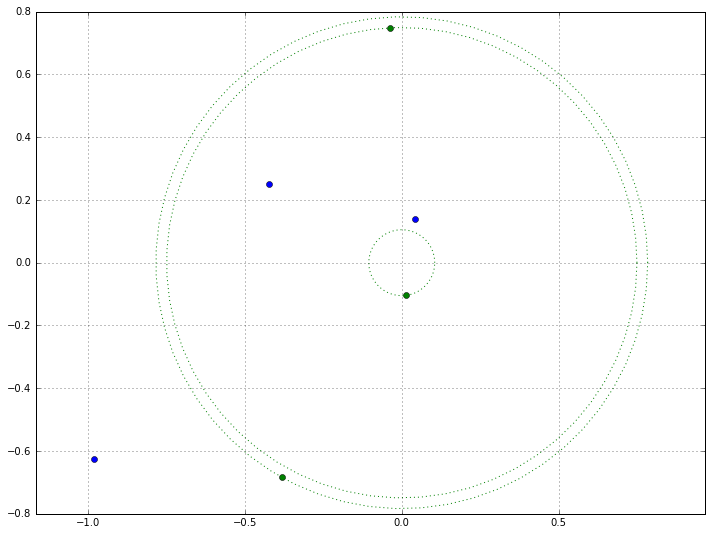

In [218]:
plt.figure(figsize=(12,9))
for iq in circ2:
    plt.plot(np.real(iq), np.imag(iq), c='g', ls=':')
#plt.plot(iq1, marker='o', ls='none')
#plt.axis(np.array([-1,1,-1,1])*1.5)
plt.axis('equal')
plt.grid()

In [185]:
# random triangle
xy1 = np.random.rand(3,2)*2-1
xy1

array([[ 0.04207535,  0.13806014],
       [-0.42348165,  0.25042051],
       [-0.98028671, -0.62576609]])

In [195]:
# covert (x,y) to complex number
iq1 = [ xy[0]+1j*xy[1] for xy in xy1 ]
# random triangle
iq2 = [ xy[0]+1j*xy[1] for xy in np.random.rand(3,2)*2-1 ]

iq1

[(0.042075345915687512+0.13806013585809196j),
 (-0.42348164543407396+0.25042050651971404j),
 (-0.98028670686948427-0.62576608866166561j)]

In [215]:
# calculate circles for the points in group 2
a = np.reshape(np.linspace(0,2*np.pi,60), (60,1))
unit = cos(a) + 1j*sin(a)
circ2 = np.reshape(np.abs(iq2), (3,1)) * unit.T
# calculate angles for points in group 1
np.angle(iq1)

array([ 1.27497738,  2.60756711, -2.57345083])

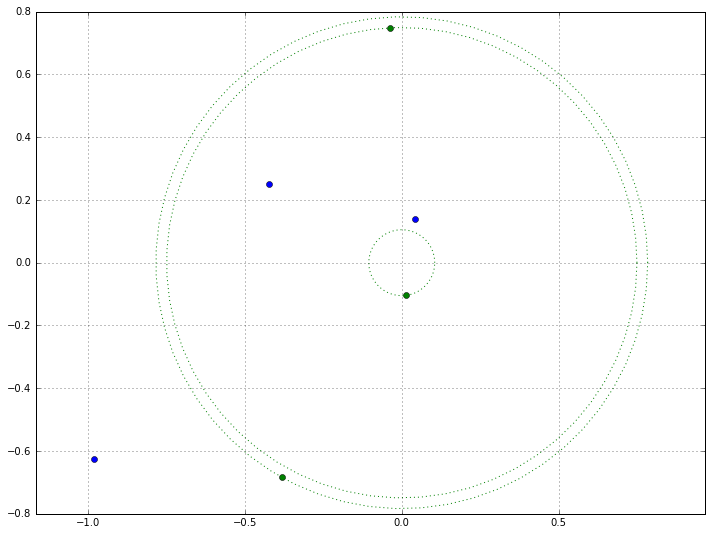

In [218]:
plt.figure(figsize=(12,9))
plt.plot(np.real(iq1), np.imag(iq1), np.real(iq2), np.imag(iq2), marker='o', linestyle='none')
for iq in circ2:
    plt.plot(np.real(iq), np.imag(iq), c='g', ls=':')
#plt.plot(iq1, marker='o', ls='none')
#plt.axis(np.array([-1,1,-1,1])*1.5)
plt.axis('equal')
plt.grid()

In [102]:
from matplotlib import pyplot as plt

# for IPython plotting
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


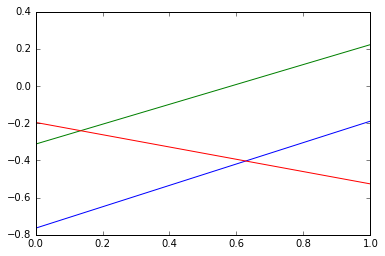

In [132]:
ax = plt.plot(tri1.T)

## More Information
### SymPy Help

Links: [Top](#Mathematical-Modeling-in-SymPy)
[Intro](#SymPy-Introduction) 
[Text](#Convert-SymPy-equations-to-text)
[LaTeX](#Convert-SymPy-equations-to-Latex)
[Solver](#Rearranging-Equations)
[Evaluating](#Evaluating-Expressions)
[Designs](#Putting-Things-Together)
[Help][]
[Help]: #Help-(Doctrings)

* _sympy.\*.subs(\*args, \*\*kwargs)_
* _sympy.lambdify(args, expr, modules=None)_

In [91]:
print(type(b.eqn[0]),'\n')
help(b.eqn[0].subs)

<class 'sympy.core.relational.Equality'> 

Help on method subs in module sympy.core.basic:

subs(*args, **kwargs) method of sympy.core.relational.Equality instance
    Substitutes old for new in an expression after sympifying args.
    
    `args` is either:
      - two arguments, e.g. foo.subs(old, new)
      - one iterable argument, e.g. foo.subs(iterable). The iterable may be
         o an iterable container with (old, new) pairs. In this case the
           replacements are processed in the order given with successive
           patterns possibly affecting replacements already made.
         o a dict or set whose key/value items correspond to old/new pairs.
           In this case the old/new pairs will be sorted by op count and in
           case of a tie, by number of args and the default_sort_key. The
           resulting sorted list is then processed as an iterable container
           (see previous).
    
    If the keyword ``simultaneous`` is True, the subexpressions will not

In [92]:
help(sympy.lambdify)

Help on function lambdify in module sympy.utilities.lambdify:

lambdify(args, expr, modules=None, printer=None, use_imps=True, dummify=True)
    Returns a lambda function for fast calculation of numerical values.
    
    If not specified differently by the user, SymPy functions are replaced as
    far as possible by either python-math, numpy (if available) or mpmath
    functions - exactly in this order. To change this behavior, the "modules"
    argument can be used. It accepts:
    
     - the strings "math", "mpmath", "numpy", "numexpr", "sympy"
     - any modules (e.g. math)
     - dictionaries that map names of sympy functions to arbitrary functions
     - lists that contain a mix of the arguments above, with higher priority
       given to entries appearing first.
    
    The default behavior is to substitute all arguments in the provided
    expression with dummy symbols. This allows for applied functions (e.g.
    f(t)) to be supplied as arguments. Call the function with dumm

### Upgrading Code to Python 3

I originally made this notebook using Python 2.7.  Fortunately, there's a Python library for that too [lib2to3](https://docs.python.org/2/library/2to3.html), although the canned `2to3` application worked just fine for me.  Although this doesn't usually change functionality, there may be some slight changes as seen when running `help` on the `sympy.lambdify` output functions.

In [93]:
%%file process.py
import sympy
import numpy as np

def parseExpr(expr=''):
    '''Helper function to iterate through a list of equations'''
    err = 'Malformed expression! Does not match "y = f(x)"\n  {0:s}'
    for s in expr.strip().split('\n'):
        # Parse anything that looks like an equation and isn't commented out
        if ('=' in s) and (s[0] != '#'):
            # convert expression to sympy
            y, f = map(str.strip, s.split('=',1))
            y = sympy.Symbol(y)
            f = sympy.sympify(f)
            assert type(y) == sympy.symbol.Symbol, err.format(s)
            yield (y, f)
                
class Block(object):
    '''Block(expr, inputs='', outputs='', functions={})
Generic processing block that performs specified calculations on given inputs
in such a way to ease documentation
    '''
    
    verbose    = True   # Enable verbose output
    outputMode = 'dict' # eval() return type ('dict' or 'tuple')
    
    def __init__(self, expr, name='', inputs='', outputs='', functions={}):
        '''Create a Block instance'''
        
        if Block.verbose:
            s = 'Creating Block(expr={:s}, name={:s}, inputs={:s}, outputs={:s}, functions='
            s = s.format(*map(repr,[expr, name, inputs, outputs]))+'{'
            if functions:
                s_functions = []
                for k, v in functions.iteritems():
                    s2 = k+':'+v.__name__
                    args, varargs, keywords, defaults = getargspec(v)
                    if varargs != None:
                        args += ['*args']
                    if keywords != None:
                        args += ['*kwargs']
                    s2 += '('+','.join(args)+')'
                    s_functions.append(s2)
                s += ','.join(s_functions)
            print s+'})'
        
        self.name = name
        self.user = functions
        
        # save in list form for ordered outputs
        eqn = tuple(parseExpr(expr))
        self.eqn = tuple([ sympy.Eq(k, v) for k, v in eqn ])
        # placeholder for compiled expressions
        self.lambdas = {}
        
        # Extract inputs and functions used
        expr_inputs = set()
        expr_functs = set()
        for k, v in eqn:
            for arg in sympy.preorder_traversal(v):
                if arg.is_Symbol:
                    expr_inputs.add(arg)
                elif arg.is_Function:
                    expr_functs.add(arg.func)
        
        # save SymPy style .args and .func attributes
        self.args = tuple(expr_inputs)
        self.func = tuple(expr_functs)     
        
        if inputs:
            self.ins = sympy.symbols(inputs)
        else: # extract inputs from expr
            self.ins = tuple(self.args)
            
        outs = tuple([ i[0] for i in eqn ])
        if outputs:
            self.outs = sympy.symbols(outputs)
            print 'outs='+repr(outs)
            self.hidden = tuple([ i for i in outs if i not in self.outs ])
        else: # extract inputs from expr
            self.outs = outs
            self.hidden = tuple()
            if Block.verbose:
                print '  Extracting outputs:', self.outs
                
        # create _eval() wrapper function with useful docstring        
        self.eval = self._wrap_eval()
                        
    def _wrap_eval(self):
        '''create _eval() wrapper function with useful docstring'''
        
        if type(self.ins) == tuple:
            ins = self.ins
            s = repr(self.ins)
        else:
            ins = (self.ins,)
            s = '('+repr(self.ins)+')'

        # not sure how to do a decorator with non-generic dynamic args
        func = sympy.lambdify(self.ins, '_eval'+s, {'_eval':self._eval})
        func.__name__ = 'Block.eval'
        s = repr(self.outs)
        if type(self.outs) != tuple:
            s = '('+s+')'
        func.__doc__ = 'Calculate outputs '+s+' as follows:\n  '
        func.__doc__ += '\n  '.join(map(str,self.eqn))
        func.__doc__ += '\n\nBlock.outputMode = '+repr(Block.outputMode)+'\n'
        
        return func
        
    def __str__(self):
        '''Support str calls on Block instances'''
        s  = 'Block: '+str(self.name)+'\n'
        s += '\n'.join( str(e).replace('==','=') for e in self.eqn )
        return s
    
    def __repr__(self):
        '''return representation that sympy will automatically show as LaTeX'''
        s = 'Block'
        if self.name:
            s += '('+self.name +')'
        return repr({s:[ sympy.Eq(sympy.Symbol(k), v) for k,v in self.eqn.items() ]})
    
    # method doesn't work currently
    __repr__ = __str__
    
    def pretty(self):
        '''Show a SymPy pretty print version of Block equations'''
        print '\nBlock:', self.name
        print '\n'.join( sympy.pretty(e) for e in self.eqn )
        
    @property
    def latex(self):
        '''generate a latex version of Block equations'''
        # \verb;*; leaves contents unformatted
        s  = r'\underline{\verb;Block: '+str(self.name)+';} \\\\ \n'
        s += ' \\\\ \n'.join( sympy.latex(e) for e in self.eqn )
        return s 
        
    def lambdify(self, unknowns=None):
        '''generate an executable function using NumPy'''
        lookup='numpy'
        
        # by default, unknowns are everything but outputs
        if unknowns == None:
            unknowns = self.outs+self.hidden
        
        if self.verbose:
            print 'Compiling Block '+repr(self.name)+' expressions:'
            
        # check for missing functions
        defined = set(dir(np) + self.user.keys())
        missing = [ f for f in self.func if str(f) not in defined ]
        if missing:
            s = 'Unable to find functions '+str(missing)+' in '+str(lookup)
            s += ' or user-defined functions ' + self.user.keys()
            raise LookupError, s
        
        # solve equations in terms of unknowns
        eqn = sympy.solve(self.eqn, unknowns, dict=True)
        if self.verbose:
            print 'Solving equations for unknowns:', unknowns 
            print self.eqn
            print ' =', eqn, '\n'
        
        s = "  {0:s} = sympy.lambdify({1:s}, {2:s}, '{3:s}')" # verbose string
        for k, v in eqn[0].iteritems():   
            if k in self.hidden: # skip intermediate values
                continue
            
            k = str(k) # convert output variable from sympy.Symbol
            
            if self.verbose:
                print s.format(*map(str, (k, self.ins, v, (lookup, self.user.keys()) )))
            f = sympy.lambdify(self.ins, v, (lookup, self.user))
            # Update the function name and doc string from "<lambda> lambda x, y, theta"
            f.__name__ = "Block"
            if self.name:
                f.__name__ += '('+self.name+')'
            f.__name__ += '.lambdas['+k+']'
            f.__doc__ = k+' = '+str(v)
            self.lambdas[k] = f
            
        return self.lambdas    
        
    def _eval(self, *args, **kwargs):
        '''evaluate outputs for given inputs'''
        
        # make sure in/ouputs are iterable
        if hasattr(self.ins, '__iter__'):
            ins = self.ins
        else:
            ins = [self.ins]
            
        # make sure all inputs are given
        assert len(args) == len(ins)

        # default kwargs values
        if not kwargs.has_key('output'):
            output=Block.outputMode
                   
        # compile expressions if needed
        if not self.lambdas:
            self.lambdify()
            
        if self.verbose:
            s = '\nBlock.eval('
            s += ', '.join( map(lambda k, v: str(k)+'='+str(v), ins, args) )
            s += ', output='+repr(output)
            print s+')\n'
        
        if output == 'dict':            
            if self.name:
                prefix=self.name+'.'
            else:
                prefix=''
            return { prefix+k:v(*args) for k, v in self.lambdas.iteritems() }
        else: # output tuple in order of .outs
            return tuple( self.lambdas[k](*args) for k in self.outs )           

Overwriting process.py


Let's test the conversion of the rewritten Python 2.7 code

In [94]:
!2to3 -w process.py

--- process.py	(original)
+++ process.py	(refactored)
@@ -8,7 +8,7 @@
         # Parse anything that looks like an equation and isn't commented out
         if ('=' in s) and (s[0] != '#'):
             # convert expression to sympy
-            y, f = map(str.strip, s.split('=',1))
+            y, f = list(map(str.strip, s.split('=',1)))
             y = sympy.Symbol(y)
             f = sympy.sympify(f)
             assert type(y) == sympy.symbol.Symbol, err.format(s)
@@ -28,10 +28,10 @@
         
         if Block.verbose:
             s = 'Creating Block(expr={:s}, name={:s}, inputs={:s}, outputs={:s}, functions='
-            s = s.format(*map(repr,[expr, name, inputs, outputs]))+'{'
+            s = s.format(*list(map(repr,[expr, name, inputs, outputs])))+'{'
             if functions:
                 s_functions = []
-                for k, v in functions.iteritems():
+                for k, v in functions.items():
                     s2 = k+':'+v.__name__
                     

RefactoringTool: Skipping optional fixer: buffer
RefactoringTool: Skipping optional fixer: idioms
RefactoringTool: Skipping optional fixer: set_literal
RefactoringTool: Skipping optional fixer: ws_comma
RefactoringTool: Refactored process.py
RefactoringTool: Files that were modified:
RefactoringTool: process.py


Success!

In [95]:
from process import *

In [96]:
for s in (parseExpr, Block):
    help(s)

Help on function parseExpr in module process:

parseExpr(expr='')
    Helper function to iterate through a list of equations

Help on class Block in module process:

class Block(builtins.object)
 |  Block(expr, inputs='', outputs='', functions={})
 |  Generic processing block that performs specified calculations on given inputs
 |  in such a way to ease documentation
 |  
 |  Methods defined here:
 |  
 |  __init__(self, expr, name='', inputs='', outputs='', functions={})
 |      Create a Block instance
 |  
 |  __repr__ = __str__(self)
 |  
 |  __str__(self)
 |      Support str calls on Block instances
 |  
 |  lambdify(*args, **kwargs) from builtins.type
 |      generate an executable function using NumPy and set the arguments to the variable names
 |  
 |  pretty(self)
 |      Show a SymPy pretty print version of Block equations
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for 

### Interesting Links / References

**Python and Jupyter Notebooks**

[Markdown syntax](https://daringfireball.net/projects/markdown/syntax)

[Notebook reveal-based slideshow tutorial](http://www.slideviper.oquanta.info/tutorial/slideshow_tutorial_slides.html#/)

[A brief tour of the IPython notebook](http://www.slideviper.oquanta.info/tutorial/slideshow_tutorial_slides.html#/14): Same presentation, just later on

[2to3 - Automated Python 2 to 3 code translation](https://docs.python.org/2/library/2to3.html)

[But do I really want to use Python 3?](https://wiki.python.org/moin/Python2orPython3) **Yes**, it's been around since 2008

[LaTeX documentation](https://www.latex-project.org/help/documentation/)

[Python Exceptions](https://docs.python.org/3/library/exceptions.html#bltin-exceptions)

**SymPy and LaTeX**

[Scientific Python Lectures: Symbolic algebra](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-5-Sympy.ipynb)

[Live SymPy console](http://live.sympy.org/)

[Wolfram Alpha-style search engine powered by SymPy](http://sympy-gamma-hrd.appspot.com/)
[SymPy Tutorial](http://docs.sympy.org/latest/tutorial/index.html)

[SymPy Modules](http://docs.sympy.org/latest/np-modindex.html#cap-s)

[SymPy solvers module](http://docs.sympy.org/latest/modules/solvers/solvers.html): Algebraic/Differential/Recurrence/Diophantine equations, Utilities, Systems of Polynomial Equations
 Equations, Inequalities

[SymPy Simplification Functions](http://docs.sympy.org/latest/tutorial/simplification.html): Function/Trigonometric/Powers/Exponentials/logarithms Simplification, Special Functions

[SymPy Basic Operations](http://docs.sympy.org/latest/tutorial/basic_operations.html#evalf): Substitution, string inputs, evalf, lambdify

[SymPy Basics of Expressions](http://mattpap.github.io/scipy-2011-tutorial/html/basics.html#the-role-of-symbols)

[SymPy Expression Trees and Manipulations](http://docs.sympy.org/latest/tutorial/manipulation.html#tutorial-manipulation)

[Embed LaTeX math equations into Microsoft Word](http://tex.stackexchange.com/questions/25223/embed-latex-math-equations-into-microsoft-word)

[Type math formulas in LaTeX way in Microsoft Word?](http://superuser.com/questions/340650/type-math-formulas-in-latex-way-in-microsoft-word)

[pyvideo.org videos for SymPy](http://pyvideo.org/search?models=videos.video&q=sympy)

**SciPy and matplotlib**

[SciPy Signal Processing module](http://docs.scipy.org/doc/scipy-0.13.0/reference/signal.html): Convolution, Filters, Linear Systems, Function Generators, Windowing, Wavelets, Peak finding, Spectral Analysis

[SciPy Special Function module](http://docs.scipy.org/doc/scipy-0.13.0/reference/special.html#error-function-and-fresnel-integrals): Elliptic, Bessel, Gamma, Error, Legendre, Hypergeometric, Mathieu, Wave, and other functions

[SciPy Cookbook: BPSK](http://wiki.scipy.org/Cookbook/CommTheory): A simple BPSK example with AWGN (no coding)

[Matplotlib Gallery](http://matplotlib.org/gallery.html): Example plots

### Any Questions?



This presentation courtesy of Python 


    jupyter nbconvert --to slides Process.ipynb --post serve

    [NbConvertApp] Converting notebook Process.ipynb to slides
    [NbConvertApp] Writing 341651 bytes to Process.slides.html
    [NbConvertApp] Redirecting reveal.js requests to https://cdn.jsdelivr.net/reveal.js/2.6.2
    Serving your slides at http://127.0.0.1:8000/Process.slides.html
    Use Control-C to stop this server
    WARNING:tornado.access:404 GET /custom.css (127.0.0.1) 4.00ms
    WARNING:tornado.access:404 GET /custom.css (127.0.0.1) 3.00ms

In [ ]:
%%file notebook_slides.bat
jupyter nbconvert --to slides Process.ipynb --post serve